# TRAINING AND TEST
# RESNET50
### Gioele Migno 1795826

In [ ]:
#name of folder in which there will be saved the nn model, the best weights, plot of training and all parameter
REF_EXPERIMENT = '1219_resnet_fc_4096'

## SETUP

In [ ]:
#muont folder on drive -
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
#folders
PWD = '/content/drive/My Drive/4.1/Machine Learning/HOMEWORKS/HW_2'

#input dataset
DATASET_ROOT = os.path.join(PWD, 'dataset')
TRAINING_SET = os.path.join(DATASET_ROOT, 'training')
VALIDATION_SET = os.path.join(DATASET_ROOT,'validation')
TEST_SET = os.path.join(DATASET_ROOT,'test')

#export result
EXPORT_ROOT = os.path.join(PWD, 'results')
if not os.path.isdir(EXPORT_ROOT):
  os.makedirs(EXPORT_ROOT)

In [ ]:
EXPORT_CURRENT_EXPERIMENT = os.path.join(EXPORT_ROOT, REF_EXPERIMENT)

SETUPS = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'setups')
MODELS = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'models')
LOG_TRAINING_TESTING = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'log_training_testing')
BEST_WEIGHTS = os.path.join(EXPORT_CURRENT_EXPERIMENT, 'weights')

In [ ]:
if os.path.isdir(EXPORT_CURRENT_EXPERIMENT):
  print("Error! Current experiment has been already performed, change REF_EXPERIMENT to run a new experiment")
  raise KeyboardInterrupt
else:
  os.makedirs(SETUPS)
  os.makedirs(MODELS)
  os.makedirs(LOG_TRAINING_TESTING)
  os.makedirs(BEST_WEIGHTS)

Error! Current experiment has been already performed, change REF_EXPERIMENT to run a new experiment


KeyboardInterrupt: ignored

In [ ]:
SETTING={
    'SEED_RANDOM':20201205,
    'OPTIMIZER':'adam',
    'BATCH_SIZE': 64,
    'IMG_HEIGHT':256,
    'IMG_WIDTH':256,
    'DATA_AUGMENTATION_LEVEL':2,
    'EPOCHS':100
}

In [ ]:
TRANSFER_NET_PARAMETERS={
    'NODES_DENSE_1':4096,
    'DROPOUT_DENSE_1':0.2,

    'NODES_DENSE_2':4096,
    'DROPOUT_DENSE_2':0.2
}

In [ ]:
def export_setting(name_setting, setting):
  #export setting
  filename = os.path.join(SETUPS, name_setting)
  file = open(filename, 'w')
  for key in setting.keys():
    file.write(key + ' = ' + str(setting[key]) + '\n')
  file.close()

In [ ]:
#export setting
export_setting('SETTING.txt', SETTING)
export_setting('TRANSFER_NET_PARAMETERS.txt', TRANSFER_NET_PARAMETERS)

## PREPROCESSING

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### DATA_AUGUMENTATION

In [ ]:
# level of data augmentation [0: none, 1: low, 2: high ]
data_augmentation_level = SETTING['DATA_AUGMENTATION_LEVEL']

batch_size = SETTING['BATCH_SIZE']
input_shape = (SETTING['IMG_HEIGHT'], SETTING['IMG_WIDTH'])

#### Training set

In [ ]:
if data_augmentation_level==0:
    train_datagen = ImageDataGenerator(
        rescale = 1. / 255)
    train_shuffle = False

elif data_augmentation_level==1:
    train_datagen = ImageDataGenerator(
        rescale = 1. / 255,\
        zoom_range=0.1,\
        rotation_range=10)
    train_shuffle = False

else:    
    train_datagen = ImageDataGenerator(
        rescale = 1. / 255,\
        zoom_range=0.1,\
        rotation_range=20,\
        width_shift_range=0.1,\
        height_shift_range=0.1,\
        horizontal_flip=True,\
        vertical_flip=False)
    train_shuffle = True

train_generator = train_datagen.flow_from_directory(
    directory=TRAINING_SET,
    target_size=input_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    seed=SETTING['SEED_RANDOM'],
    shuffle=train_shuffle)

Found 6351 images belonging to 8 classes.


#### Validation set

In [ ]:
val_datagen = ImageDataGenerator(
    rescale = 1. / 255)

val_generator = val_datagen.flow_from_directory(
    directory=VALIDATION_SET,
    target_size=input_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    seed=SETTING['SEED_RANDOM'],
    shuffle=False)

Found 804 images belonging to 8 classes.


#### Summary

In [ ]:
num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r\n" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d validation samples from %d classes.' %(val_generator.n, val_generator.num_classes))

print('Data augmentation level: %d' %(data_augmentation_level))

Image input (256, 256, 3)
Classes: ['Glass_Cleaners', 'Mixed', 'Party_Mix_snack', 'cereal_bowl', 'chocolate_drink_bottle', 'dinnerware', 'pasta_sides', 'plastic_container']

Loaded 6351 training samples from 8 classes.
Loaded 804 validation samples from 8 classes.
Data augmentation level: 2


In [ ]:
n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

## BUILD MODEL

In [ ]:
import numpy as np
import tensorflow as tf
import keras

print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
'''
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

Tensorflow version 2.4.0


"\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,\
                         UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
from keras import callbacks

In [ ]:
#set seeds
from numpy.random import seed 
seed(SETTING['SEED_RANDOM'])

tf.random.set_seed(SETTING['SEED_RANDOM'])

In [ ]:
def load_keras_network(model_name, input_shape, init_weights=None):
  #input tensor
  input_0 = Input(shape=input_shape)

  #load a keras model
  if model_name == 'vgg16':
    model = keras.applications.vgg16.VGG16(include_top=False, weights=init_weights, input_tensor=input_0)

  elif model_name == 'resnet50':
    model = keras.applications.resnet50.ResNet50(include_top=False, weights=init_weights, input_tensor=input_0)
  else:
    print('model not supported!')
    raise KeyboardInterrupt
  
  feature_extractor = keras.models.Model(inputs=input_0, outputs=model.output, name=model_name)

  _optimizer = SETTING['OPTIMIZER']
  _loss = keras.losses.categorical_crossentropy

  feature_extractor.compile(loss=_loss, optimizer=_optimizer, metrics=['accuracy'])

  return feature_extractor

In [ ]:
resnet50_model =  load_keras_network('resnet50', input_shape, init_weights='imagenet')
resnet50_model.summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
def transfer_net(keras_model, num_classes, output_layer_feat_extractor_name, trainable_layers):
  #load keras model and initialize its weights
  features_extractor = keras_model

  # set the features extractor's layers as non-trainable
  # but let train the layers in trainable_layers list
  for idx,layer in enumerate(features_extractor.layers):
    if layer.name in trainable_layers:
      layer.trainable = True
    else:
      layer.trainable = False

  #get input and output layer of features extractor
  #the output layer is indicated by output_layer_feat_extractor_name
  input_features_extractor = keras_model.get_layer(index=0).input
  output_features_extractor = keras_model.get_layer(name = output_layer_feat_extractor_name).output

  #add layers after the layer of the features extractor indicated by output_layer_feat_extractor_name

  # flat the output of a Conv layer
  flatten = Flatten()(output_features_extractor) 
  flatten_norm = BatchNormalization()(flatten)

  # add a Dense layer
  dense1 = Dropout(TRANSFER_NET_PARAMETERS['DROPOUT_DENSE_1'])(flatten_norm)
  dense1 = Dense(TRANSFER_NET_PARAMETERS['NODES_DENSE_1'], activation='relu')(dense1)
  dense1 = BatchNormalization()(dense1)
  
  # add a Dense layer
  dense2 = Dropout(TRANSFER_NET_PARAMETERS['DROPOUT_DENSE_2'])(dense1)
  dense2 = Dense(TRANSFER_NET_PARAMETERS['NODES_DENSE_2'], activation='relu')(dense2)
  dense2 = BatchNormalization()(dense2)

  # add the final output layer
  dense3 = BatchNormalization()(dense2)
  dense3 = Dense(num_classes, activation='softmax')(dense3)
  
  model = keras.models.Model(inputs=input_features_extractor, outputs=dense3, name="transferNet")
  
  _optimizer = SETTING['OPTIMIZER']
  _loss = keras.losses.categorical_crossentropy
  model.compile(loss=_loss, optimizer=_optimizer, metrics=['accuracy'])

  return model

In [ ]:

#last layer of the keras model to use (i.e. where attach the new network)
name_output_extractor = "conv5_block3_out"

#layers of the keras model that can be trained
trainable_layers = []#["block5_conv3"]

# build the transfer model
transfer_model = transfer_net(resnet50_model, num_classes, name_output_extractor, trainable_layers)
transfer_model.summary()

Model: "transferNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
________________________________________________________________________________________

In [ ]:
#tf.keras.utils.plot_model(transfer_model,  show_shapes=True)
#tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## TRAINING

In [ ]:
import pickle 

In [ ]:
model_name = 'resnet50-transfer'

In [ ]:
format_path_best_weights = os.path.join(BEST_WEIGHTS, "weights.{epoch:02d}-{val_accuracy:.4f}.hdf5")
#e.g. weights.01-0.7836.hdf5
def get_accuracy_weights(filename):
  str_accuracy = filename.split('-')[1][:-5]
  return float(str_accuracy)

get_accuracy_weights("weights.01-0.7836.hdf5")

0.7836

In [ ]:
def keep_only_best_weights(path, max_accuracy):
  for file in os.listdir(path):
    acc = get_accuracy_weights(file)
    if acc < max_accuracy:
      os.remove(os.path.join(path, file))
  if len(os.listdir(path))>1:
    print("Warning!! Two weights have the same performance!")
    raise KeyboardInterrupt
  return os.listdir(path)[0]

def save_model(model, model_name):
    filename = os.path.join(MODELS, '%s.h5' %model_name)
    model.save(filename)
    print("\nModel saved on file %s\n" %filename)

def save_history(history,problem):
    filename = os.path.join(LOG_TRAINING_TESTING, '%s.hist' %problem)
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    print("\nHystory saved on file %s\n" %filename)

def plot_history(history, path_out=None, out_filename=None):
  # list all data in history
  #history=transfer_history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  if out_filename != None:
    plt.savefig(os.path.join(path_out, "accuracy_" + out_filename))
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  if out_filename != None:
    plt.savefig(os.path.join(path_out, "loss_"+out_filename))
  plt.show()

In [ ]:
_callback_save_best_weights = tf.keras.callbacks.ModelCheckpoint(
    filepath=format_path_best_weights,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size+1

epochs = SETTING['EPOCHS']

transfer_history = transfer_model.fit(train_generator, epochs=epochs, verbose=1, callbacks=[_callback_save_best_weights],\
                    steps_per_epoch=steps_per_epoch,\
                    validation_data=val_generator,\
                    validation_steps=val_steps)

Epoch 1/100
99/99 [==============================] - 3018s 30s/step - loss: 3.6552 - accuracy: 0.3341 - val_loss: 2.8695 - val_accuracy: 0.2836
Epoch 2/100
99/99 [==============================] - 127s 1s/step - loss: 1.6870 - accuracy: 0.4452 - val_loss: 1.8189 - val_accuracy: 0.3955
Epoch 3/100
99/99 [==============================] - 129s 1s/step - loss: 1.6353 - accuracy: 0.4794 - val_loss: 1.8318 - val_accuracy: 0.4490
Epoch 4/100
99/99 [==============================] - 138s 1s/step - loss: 1.5526 - accuracy: 0.5059 - val_loss: 1.6867 - val_accuracy: 0.4353
Epoch 5/100
99/99 [==============================] - 109s 1s/step - loss: 1.4776 - accuracy: 0.5198 - val_loss: 1.5173 - val_accuracy: 0.5112
Epoch 6/100
99/99 [==============================] - 125s 1s/step - loss: 1.4732 - accuracy: 0.5198 - val_loss: 1.5799 - val_accuracy: 0.5286
Epoch 7/100
99/99 [==============================] - 127s 1s/step - loss: 1.3722 - accuracy: 0.5502 - val_loss: 1.6746 - val_accuracy: 0.5249
Epoc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


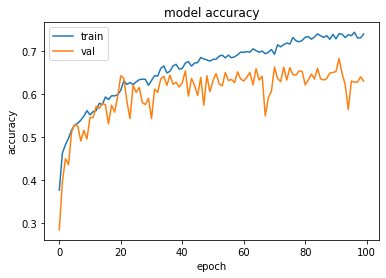

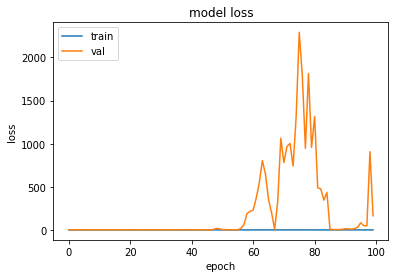

In [ ]:
plot_history(transfer_history, LOG_TRAINING_TESTING, 'plot_training.png')

In [ ]:
best_accuracy = max(transfer_history.history['val_accuracy'])
best_epoch = transfer_history.history['val_accuracy'].index(best_accuracy)
loss_at_best_accuracy= transfer_history.history['val_loss'][best_epoch]

print("Best performance (considering highest val_accuracy):")
print("\tEpoch:%s" %str(best_epoch))
print("\tVal_accuracy:%.4f" %best_accuracy)
print("\tLoss:%.4f" %loss_at_best_accuracy)

Best performance (considering highest val_accuracy):
	Epoch:91
	Val_accuracy:0.6816
	Loss:12.4924


In [ ]:
# Save trained model and hystory
save_history(transfer_history, model_name)


Hystory saved on file /content/drive/My Drive/4.1/Machine Learning/HOMEWORKS/HW_2/results/1219_resnet_fc_4096/log_training_testing/resnet50-transfer.hist



In [ ]:
#save model with the best weights
#cleanup weights folder
best_weights = keep_only_best_weights(BEST_WEIGHTS, float("%.4f" % best_accuracy))
transfer_model.load_weights(os.path.join(BEST_WEIGHTS, best_weights))
save_model(transfer_model, model_name)

NameError: ignored

In [ ]:
transfer_model.load_weights('/content/drive/My Drive/4.1/Machine Learning/HOMEWORKS/HW_2/results/1219_resnet_fc_4096/weights/weights.92-0.6816.hdf5')
save_model(transfer_model, 'resnet50')


Model saved on file /content/drive/My Drive/4.1/Machine Learning/HOMEWORKS/HW_2/results/1219_resnet_fc_4096/models/resnet50.h5



## Plot training

In [ ]:
import pickle

In [ ]:
for file in os.listdir(LOG_TRAINING_TESTING):
  if file[:5] == '.hist':
    break
file = open(os.path.join(LOG_TRAINING_TESTING, file),'r')
pickle.load(file)

UnicodeDecodeError: ignored

# TEST PERFORMANCE

In [ ]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.utils.multiclass import unique_labels

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          path_export = None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if path_export != None:
      plt.savefig(path_export)
    return ax

def export_performance(path, y_gt, y_pred, classes, title=None):
  class_perf = classification_report(y_gt, y_pred, digits=4)
  file_perf = open(os.path.join(path, "classification_report.txt"), 'w')
  file_perf.write(class_perf)
  file_perf.close()
  print(class_perf)
  plot_confusion_matrix(y_gt, y_pred, classes=classes, 
                        title=title, 
                        path_export=os.path.join(path, "confusion_matrix.png"))


### Load Test set

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=TEST_SET,
    target_size=input_shape,
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    seed=SETTING['SEED_RANDOM'],
    shuffle=False)

steps_pred = test_generator.n//test_generator.batch_size

Found 790 images belonging to 8 classes.


In [ ]:
test_generator.class_indices

{'Glass_Cleaners': 0,
 'Mixed': 1,
 'Party_Mix_snack': 2,
 'cereal_bowl': 3,
 'chocolate_drink_bottle': 4,
 'dinnerware': 5,
 'pasta_sides': 6,
 'plastic_container': 7}

### Reload model

In [ ]:
models = os.listdir(MODELS)
if len(models) != 1:
  print("Error, multiple model or no model!")
  raise KeyboardInterrupt

model_filename = os.path.join(MODELS, models[0])

In [ ]:
model = keras.models.load_model(model_filename)
model.summary()

Model: "transferNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
________________________________________________________________________________________

## VAL TEST

In [ ]:
val_datagen = ImageDataGenerator(
    rescale = 1. / 255)

val_generator = val_datagen.flow_from_directory(
    directory=VALIDATION_SET,
    target_size=input_shape,
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    seed=SETTING['SEED_RANDOM'],
    shuffle=False)

steps_pred = val_generator.n//val_generator.batch_size

Found 804 images belonging to 8 classes.


In [ ]:
preds = model.predict(val_generator, steps=steps_pred)

In [ ]:
y_pred = np.argmax(preds, axis=1)
y_gt = val_generator.classes

              precision    recall  f1-score   support

           0     0.6855    0.7083    0.6967       120
           1     0.6121    0.5966    0.6043       119
           2     0.6267    0.6267    0.6267        75
           3     0.7015    0.8319    0.7611       113
           4     0.6548    0.6111    0.6322        90
           5     0.7529    0.6598    0.7033        97
           6     0.6786    0.7525    0.7136       101
           7     0.7568    0.6292    0.6871        89

    accuracy                         0.6816       804
   macro avg     0.6836    0.6770    0.6781       804
weighted avg     0.6831    0.6816    0.6802       804

Confusion matrix, without normalization
[[85  2  3  4 12  5  8  1]
 [11 71 12  9  4  1 10  1]
 [ 1 15 47  4  5  1  2  0]
 [ 6  5  0 94  1  3  0  4]
 [ 9  7  3  2 55  3 10  1]
 [ 6  2  3  5  3 64  5  9]
 [ 0 10  5  3  3  2 76  2]
 [ 6  4  2 13  1  6  1 56]]


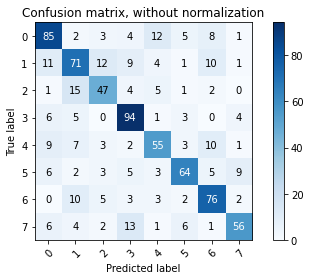

In [ ]:
export_performance(LOG_TRAINING_TESTING, y_gt, y_pred, classes=[0,1,2,3,4,5,6,7], title=None)

### Testing

In [ ]:
test_generator.reset()

preds = model.predict(test_generator, steps=steps_pred)

In [ ]:
y_pred = np.argmax(preds, axis=1)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 4, 4, 0])

In [ ]:
y_gt = test_generator.classes
y_gt[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

##### Performance Classification

In [ ]:
performance_classification = classification_report(y_gt, y_pred, digits=4)
print(performance_classification)

              precision    recall  f1-score   support

           0     0.6593    0.7542    0.7036       118
           1     0.5083    0.5214    0.5148       117
           2     0.6567    0.5946    0.6241        74
           3     0.6299    0.7143    0.6695       112
           4     0.5625    0.6136    0.5870        88
           5     0.6753    0.5474    0.6047        95
           6     0.6224    0.6162    0.6193        99
           7     0.6857    0.5517    0.6115        87

    accuracy                         0.6190       790
   macro avg     0.6250    0.6142    0.6168       790
weighted avg     0.6220    0.6190    0.6177       790



##### Confusion Matrix

Confusion matrix, without normalization
[[89  0  1  0 13  6  5  4]
 [ 3 61 11 10 10  3 16  3]
 [ 2 17 44  0  2  1  6  2]
 [ 6  9  2 80  5  4  3  3]
 [12  9  1  4 54  6  1  1]
 [ 6  5  2 13  5 52  4  8]
 [ 6 13  6  7  2  3 61  1]
 [11  6  0 13  5  2  2 48]]


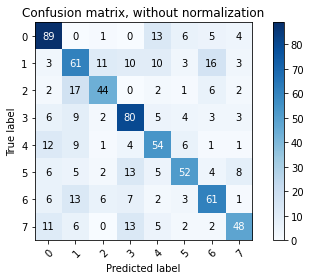

In [ ]:
plot_confusion_matrix(y_gt, y_pred, classes=[0,1,2,3,4,5,6,7])#, normalize=True)

### **Export result**

              precision    recall  f1-score   support

           0     0.6593    0.7542    0.7036       118
           1     0.5083    0.5214    0.5148       117
           2     0.6567    0.5946    0.6241        74
           3     0.6299    0.7143    0.6695       112
           4     0.5625    0.6136    0.5870        88
           5     0.6753    0.5474    0.6047        95
           6     0.6224    0.6162    0.6193        99
           7     0.6857    0.5517    0.6115        87

    accuracy                         0.6190       790
   macro avg     0.6250    0.6142    0.6168       790
weighted avg     0.6220    0.6190    0.6177       790

Confusion matrix, without normalization
[[89  0  1  0 13  6  5  4]
 [ 3 61 11 10 10  3 16  3]
 [ 2 17 44  0  2  1  6  2]
 [ 6  9  2 80  5  4  3  3]
 [12  9  1  4 54  6  1  1]
 [ 6  5  2 13  5 52  4  8]
 [ 6 13  6  7  2  3 61  1]
 [11  6  0 13  5  2  2 48]]


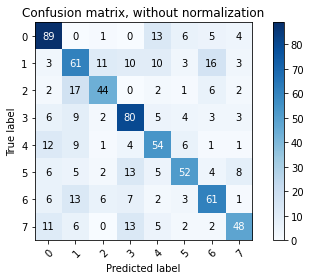

In [ ]:
export_performance(LOG_TRAINING_TESTING, y_gt, y_pred, classes=[0,1,2,3,4,5,6,7], title=None)